In [1]:
import scipy.sparse.linalg as spla
import scipy.sparse as sp
import numpy as np
import matplotlib.pyplot as plt
import time
from collections import namedtuple

In [2]:
Block = namedtuple("Block", ["length", "basis_size", "operator_dict"])
EnlargedBlock = namedtuple("EnlargedBlock", ["length", "basis_size", "operator_dict"])

def is_valid_block(block):
    for op in block.operator_dict.values():
        if op.shape[0] != block.basis_size or op.shape[1] != block.basis_size:
            return False
    return True

is_valid_enlarged_block = is_valid_block

In [3]:
# Define operators
def clock_operators(q):
    """
    Define clock model operators for q-state system.
    """
    if not isinstance(q, (int, np.integer)):
        raise TypeError(f"Expected integer for q, got {type(q)}")

    omega = np.exp(2j * np.pi / q)
    C = np.diag([omega ** n for n in range(q)])
    S = sp.lil_matrix((q, q), dtype=complex)
    for i in range(q - 1):
        S[i, i + 1] = 1
    S[q - 1, 0] = 1
    return sp.csr_matrix(C), sp.csr_matrix(S)

def apply_operator_at_site(O, i, L, q):
    """
    Places an operator O at site i in an L-site q-state system.
    """
    L = int(L)
    if not (0 <= i < L):
        raise IndexError(f"Invalid site index i={i}. Must be between 0 and {L-1}")

    I_q = sp.identity(q, format="csr")
    op_list = [I_q] * L
    op_list[i] = O

    full_operator = op_list[0]
    for op in op_list[1:]:
        full_operator = sp.kron(full_operator, op, format="csr")

    return full_operator

In [4]:
# Single-site Hamiltonian
def H1(q, h, J):
    C, S = clock_operators(q)
    
    return - h * (C + C.getH())

In [5]:
def initialize_block(q, J, h):
    return Block(length=1, basis_size=q, operator_dict={
        "H": H1(q, h, J),
        "conn_C": clock_operators(q)[0],
        "conn_S": clock_operators(q)[1],
    })

def enlarge_block(block, q, J, h):
    """Enlarges the given Block by adding a single site."""
    mblock = block.basis_size
    o = block.operator_dict

    # Single-site Hamiltonian term
    H_single = sp.kron(sp.identity(mblock), H1(q, h, J))  

    # Neighbor interaction term (only between last site and new site)
    H_interaction = -J * (sp.kron(o["conn_S"], clock_operators(q)[1].getH()) + sp.kron(o["conn_S"].getH(), clock_operators(q)[1]))

    # New enlarged Hamiltonian
    enlarged_operator_dict = {
        "H": sp.kron(o["H"], sp.identity(q)) + H_single + H_interaction,
        "conn_C": (sp.kron(sp.identity(mblock), clock_operators(q)[0])),
        "conn_S": (sp.kron(sp.identity(mblock), clock_operators(q)[1])),
    }

    return EnlargedBlock(length=(block.length + 1), basis_size=(block.basis_size * q), operator_dict=enlarged_operator_dict)

In [6]:
def single_dmrg_step(sys, env, q, J, h, m):
    """Performs a single DMRG step for the q-state clock model."""
    sys_enl = enlarge_block(sys, q, J, h)
    env_enl = sys_enl if sys is env else enlarge_block(env, q, J, h)

    # Construct the superblock Hamiltonian
    superblock_hamiltonian = (
    sp.kron(sys_enl.operator_dict["H"], sp.identity(env_enl.basis_size)) +
    sp.kron(sp.identity(sys_enl.basis_size), env_enl.operator_dict["H"]) -J *
    (sp.kron(sys_enl.operator_dict["conn_S"], env_enl.operator_dict["conn_S"].getH()) + sp.kron(sys_enl.operator_dict["conn_S"].getH(), env_enl.operator_dict["conn_S"])
    ))
    (energy,), psi0 = spla.eigsh(superblock_hamiltonian, k=1, which="SA")
    
    return sys_enl, energy

    # Call ARPACK to find the superblock ground state.  ("SA" means find the
    # "smallest in amplitude" eigenvalue.)
    (energy,), psi0 = eigsh(superblock_hamiltonian, k=1, which="SA")

    # Construct the reduced density matrix of the system by tracing out the
    # environment
    #
    # We want to make the (sys, env) indices correspond to (row, column) of a
    # matrix, respectively.  Since the environment (column) index updates most
    # quickly in our Kronecker product structure, psi0 is thus row-major ("C
    # style").
    psi0 = psi0.reshape([sys_enl.basis_size, -1], order="C")
    rho = np.dot(psi0, psi0.conjugate().transpose())

    # Diagonalize the reduced density matrix and sort the eigenvectors by
    # eigenvalue.
    evals, evecs = np.linalg.eigh(rho)
    possible_eigenstates = []
    for eval, evec in zip(evals, evecs.transpose()):
        possible_eigenstates.append((eval, evec))
    possible_eigenstates.sort(reverse=True, key=lambda x: x[0])  # largest eigenvalue first

    # Build the transformation matrix from the `m` overall most significant
    # eigenvectors.
    my_m = min(len(possible_eigenstates), m)
    transformation_matrix = np.zeros((sys_enl.basis_size, my_m), dtype='d', order='F')
    for i, (eval, evec) in enumerate(possible_eigenstates[:my_m]):
        transformation_matrix[:, i] = evec

    truncation_error = 1 - sum([x[0] for x in possible_eigenstates[:my_m]])
    print("truncation error:", truncation_error)

    # Rotate and truncate each operator.
    new_operator_dict = {}
    for name, op in sys_enl.operator_dict.items():
        new_operator_dict[name] = rotate_and_truncate(op, transformation_matrix)

    newblock = Block(length=sys_enl.length,
                     basis_size=my_m,
                     operator_dict=new_operator_dict)

    return newblock, energy

In [7]:
def graphic(sys_block, env_block, sys_label="l"):
    """Returns a graphical representation of the DMRG step we are about to
    perform, using '=' to represent the system sites, '-' to represent the
    environment sites, and '**' to represent the two intermediate sites.
    """
    assert sys_label in ("l", "r")
    graphic = ("=" * sys_block.length) + "**" + ("-" * env_block.length)
    if sys_label == "r":
        # The system should be on the right and the environment should be on
        # the left, so reverse the graphic.
        graphic = graphic[::-1]
    return graphic

In [8]:
# Infinite-system DMRG
def infinite_system_algorithm(q, J, h, L, m):
    start_time = time.time()
    block = initialize_block(q, J, h)

    while block.length < L // 2:  # Ensures final system size is L
        print("L =", block.length * 2 + 2)
        block, energy = single_dmrg_step(block, block, q, J, h, m)
        print("E/L =", energy / (block.length * 2))
        print(f"Total runtime: {time.time() - start_time:.2f} seconds\n")

In [9]:
# Finite-system DMRG
def finite_system_algorithm(q, J, h, L, m_warmup, m_sweep_list):
    assert L % 2 == 0  # require that L is an even number

    start_time = time.time()
    # To keep things simple, this dictionary is not actually saved to disk, but
    # we use it to represent persistent storage.
    block_disk = {}  # "disk" storage for Block objects

    # Use the infinite system algorithm to build up to desired size.  Each time
    # we construct a block, we save it for future reference as both a left
    # ("l") and right ("r") block, as the infinite system algorithm assumes the
    # environment is a mirror image of the system.
    block = initialize_block(q, J, h)
    block_disk["l", block.length] = block
    block_disk["r", block.length] = block
    while 2 * block.length < L:
        # Perform a single DMRG step and save the new Block to "disk"
        print(graphic(block, block))
        block, energy = single_dmrg_step(block, block, q, J, h, m=m_warmup)
        print("E/L =", energy / (block.length * 2))
        block_disk["l", block.length] = block
        block_disk["r", block.length] = block

    # Now that the system is built up to its full size, we perform sweeps using
    # the finite system algorithm.  At first the left block will act as the
    # system, growing at the expense of the right block (the environment), but
    # once we come to the end of the chain these roles will be reversed.
    sys_label, env_label = "l", "r"
    sys_block = block; del block  # rename the variable
    for m in m_sweep_list:
        while True:
            # Load the appropriate environment block from "disk"
            env_block = block_disk[env_label, L - sys_block.length - 2]
            if env_block.length == 1:
                # We've come to the end of the chain, so we reverse course.
                sys_block, env_block = env_block, sys_block
                sys_label, env_label = env_label, sys_label

            # Perform a single DMRG step.
            print(graphic(sys_block, env_block, sys_label))
            sys_block, energy = single_dmrg_step(sys_block, env_block, q, J, h, m=m)

            print("E/L =", energy / L)

            # Save the block from this step to disk.
            block_disk[sys_label, sys_block.length] = sys_block

            # Check whether we just completed a full sweep.
            if sys_label == "l" and 2 * sys_block.length == L:
                break  # escape from the "while True" loop
        end_time = time.time()
        print(f"Total runtime: {end_time - start_time:.2f} seconds")
        print("")
    return energy / L

In [ ]:
# Trying infinite-system DMRG
infinite_system_algorithm(q=2, J=1.0, h=1.0, L=16, m=20)

In [11]:
# Trying finite-system DMRG
if __name__ == "__main__":
    np.set_printoptions(precision=10, suppress=True, threshold=10000, linewidth=300)

    #infinite_system_algorithm(L=100, m=20)
    finite_system_algorithm(q = 2, J = 1.0, h=0.0, L=10, m_warmup=15, m_sweep_list=[10, 20, 30, 40])

=**-
E/L = -1.4999999999999996
==**--
E/L = -1.6666666666666685
===**---
E/L = -1.7500000000000036
====**----
E/L = -1.8000000000000003
=====**---
E/L = -1.8000000000000018
======**--
E/L = -1.8000000000000036
-------**=
E/L = -1.8000000000000014
------**==
E/L = -1.8000000000000007
-----**===
E/L = -1.8000000000000018
----**====
E/L = -1.8000000000000038
---**=====
E/L = -1.8000000000000003
--**======
E/L = -1.8000000000000018
=**-------
E/L = -1.8000000000000054
==**------
E/L = -1.800000000000005
===**-----
E/L = -1.7999999999999994
====**----
E/L = -1.8
Total runtime: 0.18 seconds

=====**---
E/L = -1.8000000000000038
======**--
E/L = -1.8000000000000032
-------**=
E/L = -1.8000000000000007
------**==
E/L = -1.8000000000000025
-----**===
E/L = -1.800000000000003
----**====
E/L = -1.8
---**=====
E/L = -1.800000000000003
--**======
E/L = -1.8
=**-------
E/L = -1.8000000000000018
==**------
E/L = -1.800000000000005
===**-----
E/L = -1.799999999999999
====**----
E/L = -1.80000000000000

In [12]:
def compute_energy_density(q, J, L, m_warmup, m_sweep_list, h):
    return finite_system_algorithm(q, J, h, L, m_warmup, m_sweep_list)

=**-
E/L = -0.7500000000000001
==**--
E/L = -0.8333333333333343
===**---
E/L = -0.8750000000000043
====**--
E/L = -0.8750000000000002
-----**=
E/L = -0.8750000000000026
----**==
E/L = -0.875
---**===
E/L = -0.8750000000000017
--**====
E/L = -0.8750000000000003
=**-----
E/L = -0.8750000000000016
==**----
E/L = -0.8749999999999992
===**---
E/L = -0.8750000000000004
Total runtime: 0.79 seconds

====**--
E/L = -0.8750000000000013
-----**=
E/L = -0.8749999999999987
----**==
E/L = -0.8749999999999992
---**===
E/L = -0.875000000000003
--**====
E/L = -0.8749999999999993
=**-----
E/L = -0.8750000000000009
==**----
E/L = -0.8750000000000004
===**---
E/L = -0.875000000000003
Total runtime: 1.41 seconds

=**-
E/L = -0.8113568768248638
==**--
E/L = -0.8832648193835836
===**---
E/L = -0.9211354599308501
====**--
E/L = -0.921135459930849
-----**=
E/L = -0.9211354599308482
----**==
E/L = -0.9211354599308431
---**===
E/L = -0.9211354599308454
--**====
E/L = -0.9211354599308461
=**-----
E/L = -0.9211354

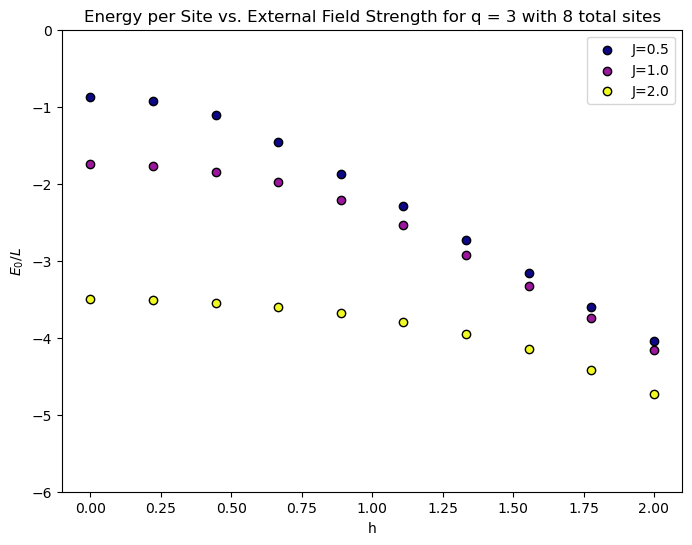

In [16]:
# Define parameters
q = 3          # Number of discrete states
J_values = [0.5, 1.0, 2.0]   # Coupling constant
L = 8         # Chain length (must be even)
m_warmup = 10  # Number of states for warmup
m_sweep_list = [10, 15]  # Number of states per sweep

# Define h values to test
h_values = np.linspace(0, 2, 10)

# Define a color map (plasma)
cmap = plt.get_cmap("plasma")

# Normalize the J values for color mapping
norm = plt.Normalize(min(J_values), max(J_values))

# Compute ground-state energy densities
results = {}

for J in J_values:
    E0_per_L = []
    for h in h_values:
        energy_densities = compute_energy_density(q, J, L, m_warmup, m_sweep_list, h)
        E0_per_L.append(energy_densities)
    results[J] = np.array(E0_per_L)

plt.figure(figsize=(8, 6))
for J in J_values:
    print(f"J = {J}, len(h_values) = {len(h_values)}, len(results[J]) = {len(results[J])}")  # Debugging
    plt.scatter(h_values, results[J], edgecolors="black", color=cmap(norm(J)), label=f"J={J}")
plt.xlabel("h")
plt.ylabel("$E_{0} / L$")
plt.title(f"Energy per Site vs. External Field Strength for q = {q} with {L} total sites")
plt.ylim(-6, 0)
plt.legend(loc='best', bbox_to_anchor=(1, 1))
plt.show()

=**-
E/L = -0.7500000000000008
==**--
E/L = -0.8333333333333326
===**---
E/L = -0.8749999999999986
====**--
E/L = -0.8750000000000012
-----**=
E/L = -0.875
----**==
E/L = -0.8750000000000002
---**===
E/L = -0.875
--**====
E/L = -0.8749999999999986
=**-----
E/L = -0.8750000000000009
==**----
E/L = -0.8749999999999996
===**---
E/L = -0.8750000000000009
Total runtime: 4.58 seconds

====**--
E/L = -0.8749999999999993
-----**=
E/L = -0.8750000000000013
----**==
E/L = -0.8749999999999998
---**===
E/L = -0.8750000000000003
--**====
E/L = -0.8749999999999991
=**-----
E/L = -0.8750000000000014
==**----
E/L = -0.8750000000000008
===**---
E/L = -0.8750000000000003
Total runtime: 8.75 seconds

=**-
E/L = -0.8328232153306031
==**--
E/L = -0.9012770572771561
===**---
E/L = -0.9378530594885414
====**--
E/L = -0.9378530594885468
-----**=
E/L = -0.9378530594885447
----**==
E/L = -0.937853059488542
---**===
E/L = -0.9378530594885426
--**====
E/L = -0.9378530594885474
=**-----
E/L = -0.9378530594885426
=

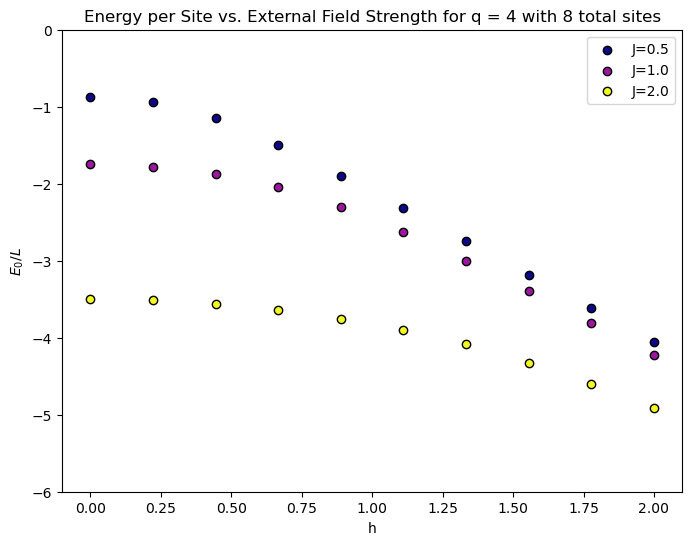

In [18]:
# Define parameters
q = 4          # Number of discrete states
J_values = [0.5, 1.0, 2.0]   # Coupling constant
L = 8         # Chain length (must be even)
m_warmup = 10  # Number of states for warmup
m_sweep_list = [10, 15]  # Number of states per sweep

# Define h values to test
h_values = np.linspace(0, 2, 10)

# Define a color map (plasma)
cmap = plt.get_cmap("plasma")

# Normalize the J values for color mapping
norm = plt.Normalize(min(J_values), max(J_values))

# Compute ground-state energy densities
results = {}

for J in J_values:
    E0_per_L = []
    for h in h_values:
        energy_densities = compute_energy_density(q, J, L, m_warmup, m_sweep_list, h)
        E0_per_L.append(energy_densities)
    results[J] = np.array(E0_per_L)

plt.figure(figsize=(8, 6))
for J in J_values:
    print(f"J = {J}, len(h_values) = {len(h_values)}, len(results[J]) = {len(results[J])}")  # Debugging
    plt.scatter(h_values, results[J], edgecolors="black", color=cmap(norm(J)), label=f"J={J}")
plt.xlabel("h")
plt.ylabel("$E_{0} / L$")
plt.title(f"Energy per Site vs. External Field Strength for q = {q} with {L} total sites")
plt.ylim(-6, 0)
plt.legend(loc='best', bbox_to_anchor=(1, 1))
plt.show()